In [1]:
# Wavefunction generation
from pyscf import mcscf, fci, lib 
from pyscf import gto, scf, tools, dft
from pyscf.dft import numint
import api as pyq 
import matplotlib.pyplot as plt
import importlib
import os
import h5py
import pdb
import pyscf
import numpy as np
from pyscf.scf.hf import dump_scf_summary
print(pyq.__file__)
print(pyscf.__file__)

/Users/ksu/Documents/GitHub/pyqmc/pyqmc/api.py
/usr/local/anaconda3/lib/python3.9/site-packages/pyscf/__init__.py


In [7]:
def run_lda_h2(scf_checkfile):
    mol = gto.M(atom="H 0. 0. 0.; H 0. 0. 1.2", spin = 2, basis=f'ccecpccpvdz', unit='bohr')
    mf = dft.UKS(mol)
    # mf.verbose=6
    mf.chkfile = scf_checkfile
    dm = mf.init_guess_by_atom()
    mf.kernel(dm, xc='LDA,VWN')
    return mf

mf = run_lda_h2(None)
mol = mf.mol

converged SCF energy = -0.666036215097532  <S^2> = 2  2S+1 = 3


In [8]:
dm = mf.make_rdm1()
kin = mf.mol.intor_symmetric('int1e_kin')
ein = mf.mol.intor_symmetric('int1e_nuc')
j, k= mf.get_jk(mf.mol, dm)

In [9]:
#Ekin
ekin = np.einsum('ij,sji->', kin, dm).real
#EI
ei = np.einsum('ij,sji->', ein, dm).real
#EJ
ej = 0.5*np.einsum('sij,sji->', j, dm).real
ek = 0.5*np.einsum('sij,sji->', k, dm).real
#ENUC
enuc = mf.energy_nuc()
print('e1', ekin + ei, 'coul', ej, 'nuc', enuc)
#Compare to PYSCF
mf.energy_tot()
print(mf.scf_summary)

e1 -1.910866543412935 coul 1.039378217566682 nuc 0.8333333333333334
{'e1': -1.9108665434129342, 'coul': 1.039378217566682, 'exc': -0.6278812225846137, 'nuc': 0.8333333333333334}


In [14]:
#Grid
size = 1000
pos = np.linspace([0.,0.,0.],[0.,0., 1.2], size)
r = np.linalg.norm(pos, axis=1)

In [15]:
#Overlaps
aox = dft.numint.eval_ao(mol, pos, deriv=2)
ao0 = aox[0]
ao1 = aox[1:4]
ao2 = aox[4:4]
orb_coeffs = mf.mo_coeff[0]

#Density Matrix
dm = mf.make_rdm1()

In [16]:
mo_value = np.einsum('ij,sjk,sk->ik', ao0, mf.mo_coeff, mf.mo_occ)
rho = np.einsum('ij,ji->i', mo_value, mo_value.T)

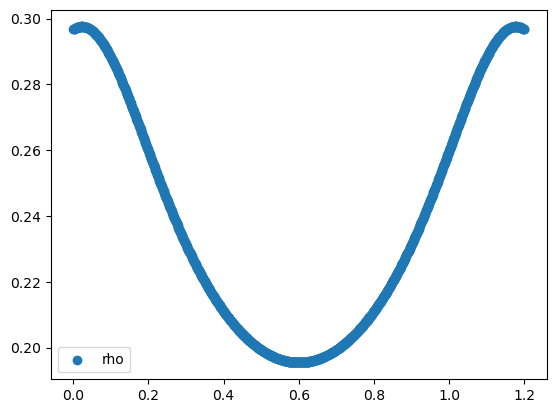

In [17]:
#user RHO
plt.scatter(r, rho, label='rho')
plt.legend()

In [18]:
# Above curve is inconsistent, lets calculate Eh using with regular grid to calculate the total hartree energy
mol = mf.mol
coords = mf.grids.coords
weights = mf.grids.weights
ao_reg_grid = numint.eval_ao(mol, coords)

mo_value_grid = np.einsum('ij,sjk,sk->ik', ao_reg_grid, mf.mo_coeff, mf.mo_occ)
mo_value_grid.shape
rho_grid = np.einsum('ij,ji, i->i', mo_value_grid, mo_value_grid.T, weights)
r_grid = np.linalg.norm(coords, axis=1)
print('Tot e: ', np.sum(rho_grid))

Tot e:  2.000000002384147


In [19]:
# using 4 different ways: https://github.com/pyscf/pyscf/blob/master/examples/1-advanced/031-MEP.py
# method 2 is wrong, does not solve poisson equation
vh = []
eh = []
for i, ri in enumerate(coords):
    with mol.with_rinv_origin(ri):
        vh.append(np.einsum('ij,sij->', mol.intor('int1e_rinv'), dm).real)
        eh.append(np.einsum('ij,sij->', mol.intor('int1e_rinv'), dm).real*rho_grid[i])
vh = np.array(vh)
eh = np.array(eh)
vh_2 = np.einsum('ij,sjk,ki->i', mo_value_grid, j, mo_value_grid.T).real    


from pyscf import df
fakemol = gto.fakemol_for_charges(coords)
vh_3 = np.einsum('ijp,sij->p', df.incore.aux_e2(mol, fakemol), mf.make_rdm1())

vh_4 = np.einsum('pij,sij->p', mol.intor('int1e_grids', grids=coords), mf.make_rdm1())

In [20]:
#Total energies compared
eh_1 = 0.5 *  np.einsum('i,i->', vh, rho_grid)
print(eh_1, ej)
eh_2 = np.einsum('i,i->', vh_2, rho_grid)
print(eh_2, ej)
eh_3 = 0.5 * np.einsum('i,i->', vh_3, rho_grid)
print(eh_3, ej)
eh_4 = 0.5 * np.einsum('i,i->', vh_4, rho_grid)
print(eh_4, ej)

1.039378219844115 1.039378217566682
0.10645029071617806 1.039378217566682
1.0393782198441142 1.039378217566682
1.0393782198441148 1.039378217566682


In [21]:
dm.shape

(2, 10, 10)